# 1 Hidden Layer Neural Network on Fischer Faces dataset

Performed PCA on to reduce the dimension from 10201 to K and then using Backpropagation algorithm to  
train a 1 Hidden layer Neural Network for Emotion Classification using Fischer Faces dataset.

Libraries used:
1) Numpy - for numerical computations such as eig(), matmul(), dot operator
2) Pillow - to read the .gif file
3) Matplotlib - to plot the graph

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

### Function get_data() 

#### Input
Folder name - either train or test

#### Output
The image data of dimension 101 x 101 is returned as numpy array X of shape (Number of images in folder, Dimension of image)  
Labels - Happy (1) or Sad (2) - of the corresponding images

In [2]:
def get_data(folder):
    labels = [[], []]    

    for dirname, _, filenames in os.walk("Data/emotion_classification/"+ folder):
        i = 0
        for filename in filenames:   
            if "happy" in filename:
                labels[0].append(i)
            else:
                labels[1].append(i)
            i+=1

            gif = Image.open(os.path.join(dirname, filename))

            data = np.asarray(gif)

            x = data.reshape(1,101*101)

            if i == 1:
                X = x
            else:
                X = np.vstack((X, x))

    print("Input Data Shape", X.shape)
    print("Input Data", X)
    
    return X, labels

In [3]:
X, labels = get_data('train')

Input Data Shape (20, 10201)
Input Data [[133 142 146 ...  95  95  95]
 [115 115 117 ... 220 227 213]
 [ 71  87 105 ...  65  66  71]
 ...
 [ 65  76  83 ...  57  53  54]
 [ 13  17  22 ... 255 255 255]
 [ 23  20  17 ... 121 215 255]]


### Function calculate_mean()

#### Input 
X - any numpy array

#### Output
Mean of the input data calculated along the column

In [4]:
def calculate_mean(X):
    mean = np.sum(X, axis=0)
    mean = mean / len(X)

    print("Mean of input", mean.shape, mean)
    
    return mean

In [5]:
K = 12

from sklearn.decomposition import PCA

pca = PCA(n_components = K)

P = pca.fit_transform(X)

### Function get_labels()

Returns the label vector with each entry corresponding to the label of each image in data point

In [6]:
def get_labels(labels):
    y = []
    
    N = sum([len(i) for i in labels])
    for i in range(N):
        if i in labels[0]:
            y.append(1)
        else:
            y.append(2)

    print("Labels", y)
    return y

### Function one_hot_encoding(y):

Converts the target labels to one hot encoding

In [7]:
def one_hot_encoding(y):
    t = np.zeros((len(y), 2, 1))
    
    for i in range(len(y)):
        t[i,y[i]-1,0] = 1
    return t

In [8]:
y = get_labels(labels)
t = one_hot_encoding(y)

Labels [1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2]


##### Takes in the Test image data as input

In [9]:
X_test, labels_test = get_data('test')

Input Data Shape (10, 10201)
Input Data [[158 167 174 ... 118 117 118]
 [ 52  64  75 ...  60 136 224]
 [110 111 111 ...  74  73  78]
 ...
 [ 10  16  22 ...  62  64  62]
 [ 58  91 111 ...  43  50  57]
 [123 123 123 ...  65  78  96]]


##### PCA projects the Test data to K-Dimensional vector

In [10]:
P_test = pca.transform(X_test)

In [11]:
y_test = get_labels(labels_test)
t_test = one_hot_encoding(y_test)

Labels [2, 1, 1, 1, 2, 1, 1, 2, 1, 2]


### Class Neural Network

Implements the 1-Hidden layer Neural Network to classify the sad/happy classes.  

It uses the cross entropy loss function and softmax output activation and ReLU hidden activation.  

Parameters - $ { W_0, b_0, W_1, b_1 } $

#### Function forward_pass(x):  

Given a data point, performs the forward pass of the algorithm.  

Computes:

$ a_1 = W_0.x + b_0 $  
$ z_1 = ReLU(a_1) $  
$ a_2 = W_1.z_1 + b_1 $  
$ y   = softmax(a_2) $  

#### Function backward_pass(x):  

Given a data point and its target, computes the forward pass of the backpropagation algorithm.  

Computes:  

$ \delta_1 = y - t $  
$ \delta_0 = W_1.\delta_1 \odot softmax'(a_1) $   

$ \frac{\partial E}{\partial W_1} = z_1.\delta_1^T $  
$ \frac{\partial E}{\partial b_1} = \delta_1 $   

$ \frac{\partial E}{\partial W_1} = x.\delta_0^T $  
$ \frac{\partial E}{\partial b_1} = \delta_0 $  

#### Function update_weights():  

Computes:  

$ W_1^{t+1} = W_1^t - \eta.\frac{\partial E}{\partial W_1} $  
$ b_1^{t+1} = b_1^t - \eta.\frac{\partial E}{\partial b_1} $  

$ W_0^{t+1} = W_0^t - \eta.\frac{\partial E}{\partial W_0} $  
$ b_0^{t+1} = b_0^t - \eta.\frac{\partial E}{\partial b_0} $  

#### Softmax(a)

Computes: 

$ softmax(a) = \frac{e^{a_i}}{\sum_{j=1}^K e^{a_j}} $

Derivative:

$ softmax'(a) = softmax(a) * (1 - softmax(a)) $  

#### ReLU(a)

returns max(0, a)  

Derivative:

if a <= 0: 0
else: 1

#### Cross Entropy

returns - (t.log(y) + (1 - t)(1 - log(y)))  

#### Function predict(X, t)

Predicts the output y for a given data point and calculates the overall accuracy

In [12]:
class Neural_Network:
    
    def __init__(self, layer_size, lr = 0.00001):
        self.input_layer_size = layer_size[0]
        self.hidden_layer_size = layer_size[1]
        self.output_layer_size = layer_size[2]
        
        self.lr = lr
        np.random.seed(2)
        self.params = {
            'w0': np.random.randn(self.hidden_layer_size, self.input_layer_size),
            'b0': np.random.randn(self.hidden_layer_size, 1),
            'w1': np.random.randn(self.output_layer_size, self.hidden_layer_size),
            'b1': np.random.randn(self.output_layer_size, 1)
        }
    
    
    def forward_pass(self, x):
        
        # Performs the forward pass
        
        self.nn_state = {}
        self.nn_state['x'] = x
        self.nn_state['a1'] = np.dot(self.params['w0'], self.nn_state['x'].reshape((self.input_layer_size, 1))) + self.params['b0']
        self.nn_state['z1'] = self.ReLu(self.nn_state['a1'])
        self.nn_state['a2'] = np.dot(self.params['w1'], self.nn_state['z1']) + self.params['b1']
        self.nn_state['y'] = self.softmax(self.nn_state['a2'])
        
    def backward_pass(self, x, t):
        
        # Performs the backward pass
        
        self.nn_state['d1'] = self.nn_state['y'] - t        
        self.nn_state['d0'] = np.dot(self.nn_state['d1'].T, self.params['w1']).T * self.ReLu(self.nn_state['a1'], derivative = True)
        
        self.nn_state['D2w'] = np.dot(self.nn_state['z1'], self.nn_state['d1'].T)
        self.nn_state['D2b'] = self.nn_state['d1']
        
        self.nn_state['D1w'] = np.dot(self.nn_state['d0'], self.nn_state['x'].reshape((1,self.input_layer_size)))
        self.nn_state['D1b'] = self.nn_state['d0']
        
    def update_weights(self):
        
        # Updates weight
        
        self.params['w0'] -= self.lr * self.nn_state['D1w']
        self.params['b0'] -= self.lr * self.nn_state['D1b']
        self.params['w1'] -= self.lr * self.nn_state['D2w'].T
        self.params['b1'] -= self.lr * self.nn_state['D2b']
        
        
    def softmax(self, x, derivative = False):
        
        # For stability, shifted values down, so max = 0
        
        exp_shifted = np.exp(x - x.max())
        if derivative:
            return exp_shifted / np.sum(exp_shifted, axis = 0) * (1 - exp_shifted / np.sum(exp_shifted, axis = 0))
        else:
            return exp_shifted / np.sum(exp_shifted, axis = 0)

    def ReLu(self, x, derivative = False):
        if derivative:
            return np.where(x <= 0, 0, 1)
        else:
            return np.maximum(0, x)
        
    def cross_entropy(self, t, y, derivative = False):
        
        y = np.where(y == 0, 0.00000001, y)
        y = np.where(y == 1, 0.99999999, y)
        if derivative:
            return  (-(t/y)) + ((1 - t)/(1 - y)) 
        else:
            c = np.dot(t.T, np.log(y)) + np.dot((1 - t).T, np.log(1 - y))
            return -c
        
    def predict(self, X, t):
        
        # Predicts the output and calculates accuracy
        
        acc = 0
        for i in range(len(t)):
            self.forward_pass(X[i])
            
            if np.argmax(model.nn_state['y']) == np.argmax(t[i]):
                acc += 1
        return acc / len(t)

## 1-Hidden Layer Neural Network with 10 hidden Neurons

################### Training ####################
----- Epoch: 1  -----
Cost: 26.9161 Accuracy: 0.45
----- Epoch: 2  -----
Cost: 48.8571 Accuracy: 0.5
----- Epoch: 3  -----
Cost: 61.6795 Accuracy: 0.5
----- Epoch: 4  -----
Cost: 53.7584 Accuracy: 0.55
----- Epoch: 5  -----
Cost: 61.7028 Accuracy: 0.55
----- Epoch: 6  -----
Cost: 10.1472 Accuracy: 0.75
----- Epoch: 7  -----
Cost: 9.2103 Accuracy: 0.75
----- Epoch: 8  -----
Cost: 17.7666 Accuracy: 0.75
----- Epoch: 9  -----
Cost: 27.1089 Accuracy: 0.65
----- Epoch: 10  -----
Cost: 36.6838 Accuracy: 0.75
----- Epoch: 11  -----
Cost: 3.6841 Accuracy: 0.9
----- Epoch: 12  -----
Cost: 53.8544 Accuracy: 0.7
----- Epoch: 13  -----
Cost: 66.2226 Accuracy: 0.85
----- Epoch: 14  -----
Cost: 1.8421 Accuracy: 0.95
----- Epoch: 15  -----
Cost: 22.2918 Accuracy: 0.95
----- Epoch: 16  -----
Cost: 5.8374 Accuracy: 0.95
----- Epoch: 17  -----
Cost: 0.0 Accuracy: 1.0
----- Epoch: 18  -----
Cost: 0.0 Accuracy: 1.0
----- Epoch: 19  -----
Cost: 0.0 Accuracy

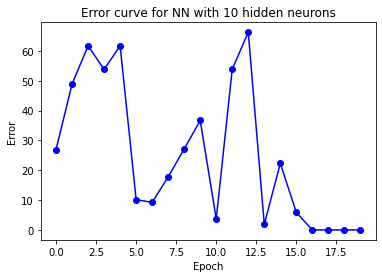

In [13]:
layer_sizes = [K, 10, 2]
model = Neural_Network(layer_sizes)

num_epochs = 20

print('################### Training ####################')
plot_cost = []
for e in range(num_epochs):
    print('----- Epoch:', e+1, ' -----')
    
    samples = P.shape[0]
    cost = 0
    acc = 0
    for i in range(samples):
        model.forward_pass(P[i])
        model.backward_pass(P[i], t[i])
        
        # Add Partial Cost of a training datapoint
        cost += model.cross_entropy(t[i], model.nn_state['y'])
        
        # Update Weights
        model.update_weights()
        
        if np.argmax(model.nn_state['y']) == np.argmax(t[i]):
            acc += 1

    # Training Accuracy
    cost = cost / samples
    plot_cost.append(cost[0])
    accuracy = acc / samples
    print('Cost:', round(cost[0,0],4), 'Accuracy:', accuracy)
    
# Plotting the Error Curve
plt.plot([i for i in range(num_epochs)], plot_cost, marker="o", color='b') 
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error curve for NN with 10 hidden neurons')
plt.show()

In [14]:
print("Test Accuracy: ", model.predict(P_test, t_test)*100, " %")

Test Accuracy:  70.0  %


## 1-Hidden Layer Neural Network with 15 hidden Neurons

################### Training ####################
----- Epoch: 1  -----
Cost: 23.94688497087198 Accuracy: 0.35
----- Epoch: 2  -----
Cost: 40.64580029187142 Accuracy: 0.35
----- Epoch: 3  -----
Cost: 56.01204411031657 Accuracy: 0.45
----- Epoch: 4  -----
Cost: 14.736544603652112 Accuracy: 0.6
----- Epoch: 5  -----
Cost: 49.79125663742088 Accuracy: 0.45
----- Epoch: 6  -----
Cost: 43.152332099976256 Accuracy: 0.65
----- Epoch: 7  -----
Cost: 21.463261922446996 Accuracy: 0.85
----- Epoch: 8  -----
Cost: 7.815961832542122 Accuracy: 0.95
----- Epoch: 9  -----
Cost: 41.2395858463644 Accuracy: 0.8
----- Epoch: 10  -----
Cost: 24.207747302207537 Accuracy: 0.9
----- Epoch: 11  -----
Cost: 15.58088523651897 Accuracy: 0.9
----- Epoch: 12  -----
Cost: 57.58767488080722 Accuracy: 0.8
----- Epoch: 13  -----
Cost: 25.61824616058368 Accuracy: 0.9
----- Epoch: 14  -----
Cost: 0.4074539970440167 Accuracy: 0.95
----- Epoch: 15  -----
Cost: 1.0198703621666065e-06 Accuracy: 1.0
----- Epoch: 16  -----
Cost

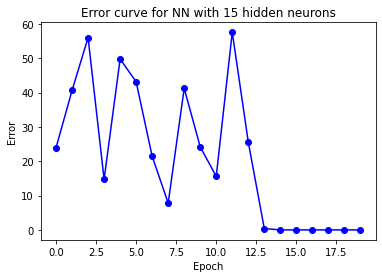

In [15]:
layer_sizes = [K, 15, 2]
model = Neural_Network(layer_sizes)

num_epochs = 20

print('################### Training ####################')
plot_cost = []
for e in range(num_epochs):
    print('----- Epoch:', e+1, ' -----')
    
    samples = P.shape[0]
    cost = 0
    acc = 0
    for i in range(samples):
        model.forward_pass(P[i])
        model.backward_pass(P[i], t[i])
        
        # Add Partial Cost of a training datapoint
        cost += model.cross_entropy(t[i], model.nn_state['y'])
        
        # Update Weights
        model.update_weights()
        
        if np.argmax(model.nn_state['y']) == np.argmax(t[i]):
            acc += 1

    # Training Accuracy
    cost = cost / samples
    plot_cost.append(cost[0])
    accuracy = acc / samples
    print('Cost:', cost[0,0], 'Accuracy:', accuracy)
    
    
# Plotting the Error Curve
plt.plot([i for i in range(num_epochs)], plot_cost, marker="o", color='b') 
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error curve for NN with 15 hidden neurons')
plt.show()

In [16]:
print("Test Accuracy: ", model.predict(P_test, t_test)*100, " %")

Test Accuracy:  80.0  %


## When the number of hidden neurons got increased from 10 to 15, the test accuracy got increased from 70% to 80%.

## It follows the same trend and the test accuracy reaches 90% when there are 25 hidden neurons.